In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [36]:
# Ensure the project root is in the Python path for module imports
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [38]:
from simulation.gen_pend import *

param_dists = {
    'q': stats.uniform(-np.pi, 2 * np.pi),
    'v': stats.uniform(-1., 2.),
    'b': stats.uniform(0., 0.)
}

times, trajs = gen_trajs(10_000, 5., 64, param_dists)

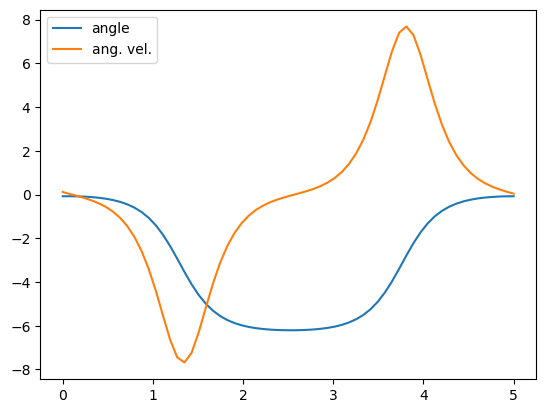

In [39]:
# plot a random trajectory
i = np.random.randint(10_000)
plt.plot(times, trajs[i, 0], label='angle');
plt.plot(times, trajs[i, 1], label='ang. vel.')
plt.legend();

Since Pinocchio doesn't give the angles mod 2pi, the angular measurements could get very large. We'll stick to short time-frames so that this doesn't become a problem.

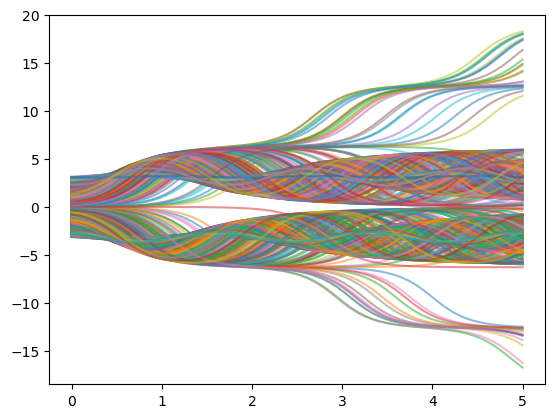

In [40]:
for i in range(1000):
    plt.plot(times, trajs[i, 0], alpha=.5)

## Splitting the trajectories into windows


In [29]:
class TrajWindowsDataset(Dataset):
    def __init__(self, trajs, window):
        super().__init__()
        self.window = window
        self.n_simulations, _, self.n_steps = trajs.shape
        assert window <= self.n_steps
        self.windows_per_traj = self.n_steps - self.window + 1

    def __len__(self):
        return self.n_simulations * self.windows_per_traj

    def __getitem__(self, idx):
        i = idx // self.windows_per_traj
        j = idx % self.windows_per_traj
        return trajs[i, :, j:(j+self.window)]

In [358]:
window = 20
X = TrajWindowsDataset(trajs, window)
dl = DataLoader(X, batch_size=256, shuffle=True)

## MLP

In [44]:
X_tr, X_val = random_split(torch.tensor(trajs), [0.6, 0.4])
dl_tr = DataLoader(X_tr, batch_size=256, shuffle=True)
dl_val = DataLoader(X_val, batch_size=256, shuffle=True)

In [45]:
class TrajEnc(nn.Module):

    def __init__(self, window, n_features, latent_dim):
        super(TrajEnc, self).__init__()

        self.window = window
        self.n_features = n_features

        input_dim = window * n_features

        self.enc = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.ReLU(),
            nn.Linear(input_dim // 4, latent_dim)
        )

        self.dec = nn.Sequential(
            nn.Linear(latent_dim, input_dim // 4),
            nn.ReLU(),
            nn.Linear(input_dim // 4, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim)
            # no relu: don't want to restrict output range
        )

    def forward(self, x):
        # x: (bs, n_features, window)
        x = torch.flatten(x, start_dim=1) # x: (bs, n_features * window)
        u = self.enc(x)
        rec = torch.unflatten(self.dec(u), dim=1, sizes=(self.n_features, self.window))
        return rec, u

## Training the model

In [46]:
model = TrajEnc(64, 2, 2)

opt = optim.Adam(model.parameters(), lr=2e-3)
loss_fn = nn.MSELoss()

print(f'# params: {sum(p.numel() for p in model.parameters())}')

# params: 20930


In [47]:
n_epochs = 300

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # --- Training ---
    model.train()
    train_loss = 0.0
    
    for batch_idx, x in enumerate(dl_tr):
        opt.zero_grad()
        rec, lat = model(x)
        loss = loss_fn(rec, x)
        loss.backward()
        opt.step()

        train_loss += loss.item() * x.size(0)

    train_loss /= len(dl_tr.dataset)
    train_losses.append(train_loss)

    # --- Validation ---
    model.eval()
    val_loss = 0.0

    for batch_idx, x in enumerate(dl_val):
        rec, lat = model(x)
        loss = loss_fn(rec, x)
        val_loss += loss.item() * x.size(0)

    val_loss /= len(dl_val.dataset)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Tr Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")

Epoch [10/300], Tr Loss: 2.4579 Val Loss: 2.3512
Epoch [20/300], Tr Loss: 0.6995 Val Loss: 0.7128
Epoch [30/300], Tr Loss: 0.4823 Val Loss: 0.5769
Epoch [40/300], Tr Loss: 0.3823 Val Loss: 0.4361
Epoch [50/300], Tr Loss: 0.3373 Val Loss: 0.3745
Epoch [60/300], Tr Loss: 0.2936 Val Loss: 0.3287
Epoch [70/300], Tr Loss: 0.2682 Val Loss: 0.3131
Epoch [80/300], Tr Loss: 0.2396 Val Loss: 0.2699
Epoch [90/300], Tr Loss: 0.2275 Val Loss: 0.2502
Epoch [100/300], Tr Loss: 0.2323 Val Loss: 0.2563
Epoch [110/300], Tr Loss: 0.2346 Val Loss: 0.2389
Epoch [120/300], Tr Loss: 0.2178 Val Loss: 0.2410
Epoch [130/300], Tr Loss: 0.1993 Val Loss: 0.2357
Epoch [140/300], Tr Loss: 0.2211 Val Loss: 0.2473
Epoch [150/300], Tr Loss: 0.1862 Val Loss: 0.2068
Epoch [160/300], Tr Loss: 0.1777 Val Loss: 0.2056
Epoch [170/300], Tr Loss: 0.1797 Val Loss: 0.2018
Epoch [180/300], Tr Loss: 0.1756 Val Loss: 0.1893
Epoch [190/300], Tr Loss: 0.1579 Val Loss: 0.1873
Epoch [200/300], Tr Loss: 0.1698 Val Loss: 0.1780
Epoch [21

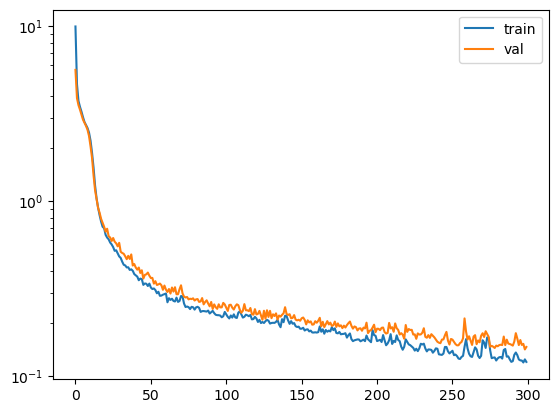

In [48]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.yscale('log')
plt.legend()

In [34]:
save_path = 'mlp.pth'
if not os.path.exists(save_path):
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to '{save_path}'")
else:
    print(f"Model already exists at '{save_path}'; not overwriting.")

Model already exists at 'mlp.pth'; not overwriting.


## Testing the model

In [ ]:
# load if needed
model = TrajEnc(64, 2, 2)
model.load_state_dict(torch.load('mlp.pth'))

RuntimeError: Error(s) in loading state_dict for TrajEnc:
	Missing key(s) in state_dict: "enc.0.weight", "enc.0.bias", "enc.2.weight", "enc.2.bias", "enc.4.weight", "enc.4.bias", "dec.0.weight", "dec.0.bias", "dec.2.weight", "dec.2.bias", "dec.4.weight", "dec.4.bias". 
	Unexpected key(s) in state_dict: "encoder.convs.0.weight", "encoder.convs.0.bias", "encoder.convs.1.weight", "encoder.convs.1.bias", "encoder.convs.1.running_mean", "encoder.convs.1.running_var", "encoder.convs.1.num_batches_tracked", "encoder.convs.3.weight", "encoder.convs.3.bias", "encoder.convs.4.weight", "encoder.convs.4.bias", "encoder.convs.4.running_mean", "encoder.convs.4.running_var", "encoder.convs.4.num_batches_tracked", "encoder.convs.6.weight", "encoder.convs.6.bias", "encoder.convs.7.weight", "encoder.convs.7.bias", "encoder.convs.7.running_mean", "encoder.convs.7.running_var", "encoder.convs.7.num_batches_tracked", "encoder.fc_mean.weight", "encoder.fc_mean.bias", "encoder.fc_logvar.weight", "encoder.fc_logvar.bias", "decoder.fc.weight", "decoder.fc.bias", "decoder.deconvs.0.weight", "decoder.deconvs.0.bias", "decoder.deconvs.1.weight", "decoder.deconvs.1.bias", "decoder.deconvs.1.running_mean", "decoder.deconvs.1.running_var", "decoder.deconvs.1.num_batches_tracked", "decoder.deconvs.3.weight", "decoder.deconvs.3.bias", "decoder.deconvs.4.weight", "decoder.deconvs.4.bias", "decoder.deconvs.4.running_mean", "decoder.deconvs.4.running_var", "decoder.deconvs.4.num_batches_tracked", "decoder.deconvs.6.weight", "decoder.deconvs.6.bias". 

In [49]:
with torch.no_grad():
    _, latents = model(torch.tensor(trajs))

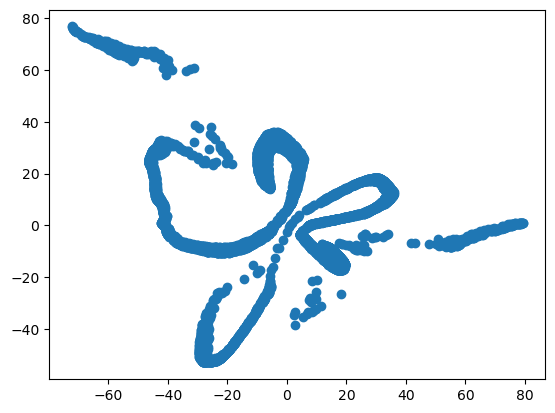

In [50]:
plt.scatter(*latents.T)

## Plot trajectories of most similar latents

In [81]:
def plot_most_similar(latents, pt, num, ax):
    "Plot the trajectories that have the num closest latents to pt."
    dists = np.linalg.norm(latents - pt, axis=1)
    closest_idxs = np.argsort(dists)[:num]
    for idx in closest_idxs:
        ax.plot(times, trajs[idx, 0, :], alpha=.3)

/var/folders/c2/vhmqh4t566q95zcjystvh20c0000gn/T/ipykernel_14109/4048237539.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dists = np.linalg.norm(latents - pt, axis=1)


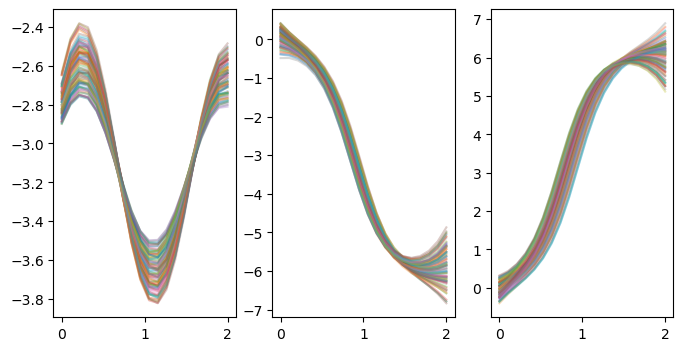

In [82]:
fig, axs = plt.subplots(1, 3, figsize=(8, 4))
plot_most_similar(latents, np.array([0, -20]), 100, axs[0])
plot_most_similar(latents, np.array([15, -20]), 100, axs[1])
plot_most_similar(latents, np.array([20, 20]), 100, axs[2])

## Testing the latents

In [24]:
from latent_app import create_dash_app

In [34]:
app = create_dash_app(latents.numpy()[::2], trajs[::2, 0])
app.run()

Note: the shorter the period of simulation, the less varied the set of trajectories, hence the more regular the latents of the MLP

## Testing trajectories outside of the training distribution

In [23]:
_, traj_ood = gen_one_traj(5., 64, np.pi/4, 10., 1.)
traj_ood = traj_ood.reshape(1, 2, -1)  # Reshape to match the input shape of the model

with torch.no_grad():
    _, latents_ood = model(torch.tensor(traj_ood))
latents_ood

tensor([[-4.3434, 51.4034]])

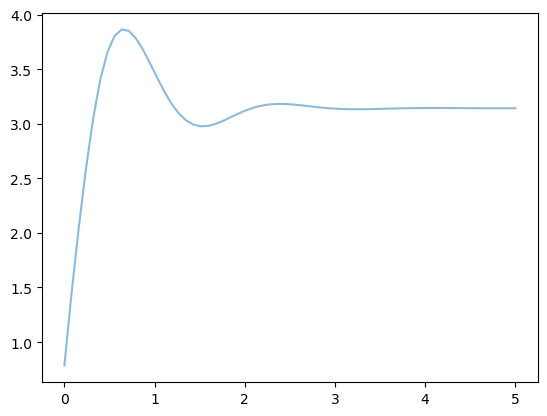

In [24]:
plt.plot(times, traj_ood[0, 0], alpha=.5)

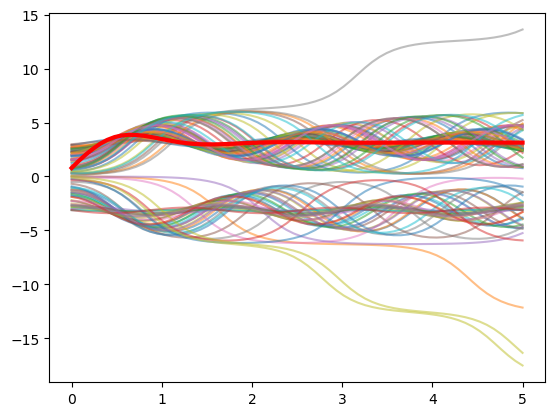

In [25]:
for i in range(100):
    plt.plot(times, trajs[i, 0], alpha=.5)
plt.plot(times, traj_ood[0, 0], color='red', lw=3)

## Using CD poly

In [26]:
from cd_poly.cd_poly import *

In [27]:
p = CDPolynomial(latents, degree=8)
alpha = p(latents).max()

In [28]:
alpha

np.float64(6955.808073401451)

Note: a cutoff significantly less than the max value on the datapoints seems better at capturing the shape of the support.

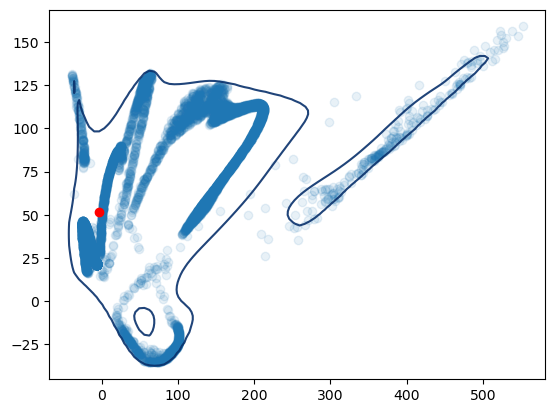

In [29]:
fig, ax = plt.subplots()
ax.scatter(*latents.numpy().T, alpha=0.1)
ax.scatter(*latents_ood.T, color='red')
plot_level_set(p, alpha / 10, ax)

## Testing custom trajectories

Let's create a custom trajectory that couldn't be generated by the simulation with our distribution of parameters.

In [30]:
amp = 1.5
freq = 13.
const = 4
custom = np.array([amp * np.sin(freq * times) + const * times, amp * freq * np.cos(freq * times) + const])

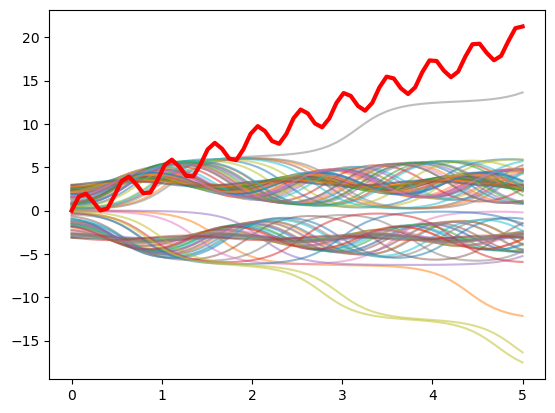

In [31]:
for i in range(100):
    plt.plot(times, trajs[i, 0], alpha=.5)
plt.plot(times, custom[0], color='red', lw=3)

In [32]:
with torch.no_grad():
    _, latents_custom = model(torch.tensor(custom.reshape(1, 2, -1)))
latents_custom

tensor([[-40.2352, 185.1881]])

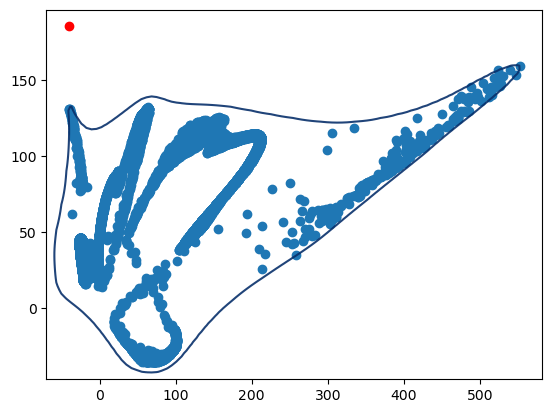

In [33]:
fig, ax = plt.subplots()
ax.scatter(*latents.numpy().T)
ax.scatter(*latents_custom.T, color='red')
plot_level_set(p, alpha, ax)